In [72]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [73]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
from quetzal.io import excel
if manual:
    %matplotlib inline

In [74]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [75]:
sm = stepmodel.read_zippedpickles(training_folder + r'model/{scen}/road_model'.format(scen=scenario))


zones: 100%|███████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 25.41it/s]


In [76]:
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario,
                               )


# CLUSTERING

In [77]:
sm.preparation_clusterize_nodes(300) # group_id='parent_station'

In [78]:
kwargs = var["preparation_footpaths"].to_dict()

# FOOTPATHS

In [79]:
kwargs

{'max_length': 3000, 'speed': 3, 'n_clusters': 3000}

In [80]:
sm.preparation_footpaths(**kwargs)

# ACCESS AND EGRESS

In [81]:
kwargs = var["preparation_ntlegs"].to_dict()

In [82]:
kwargs

{'n_ntlegs': 5,
 'max_ntleg_length': 5000,
 'long_leg_speed': 7,
 'short_leg_speed': 3,
 'threshold': 500}

In [83]:
sm.preparation_ntlegs(zone_to_transit=True,
    zone_to_road=True,**kwargs)

In [84]:
sm.zone_to_transit.index = 'ztt_' + sm.zone_to_transit.index.astype(str)
sm.zone_to_road.index =  'ztr_' + sm.zone_to_road.index.astype(str)
sm.road_to_transit.index = 'rtt_' + sm.road_to_transit.index.astype(str)

# TO ZIP

In [86]:
sm.to_zippedpickles(training_folder + 'model/{scen}/walk_model'.format(scen=scenario))  

zone_to_road: 100%|████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 12.80it/s]


# PLOT 
## clustering

In [87]:
def plot_clustering(self, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True) 
    plot = sm.plot(
        'disaggregated_nodes', markersize=10, color='green',
        basemap_url=url, title="Original Stops", fontsize=36, ax=ax_array[0][0],
    )
    plot = sm.plot(
        'node_parenthood', linewidth=1,
        ax=sm.plot('disaggregated_nodes',  markersize=10, color='green', ax=ax_array[0][1]),
        basemap_url=url, title="Stop Clusters", fontsize=36
    )
    plot = sm.plot(
        'nodes', color='green', markersize=10,
        ax=sm.plot('node_clusters', alpha=0.25, edgecolor='black', ax=ax_array[1][0]),
        basemap_url=url, title="Stop Clusters", fontsize=36
    )
    plot = sm.plot(
        'nodes', color='green', markersize=50, basemap_url=url,
        title="Aggregated stops", fontsize=36, ax=ax_array[1][1]
    )
    return fig

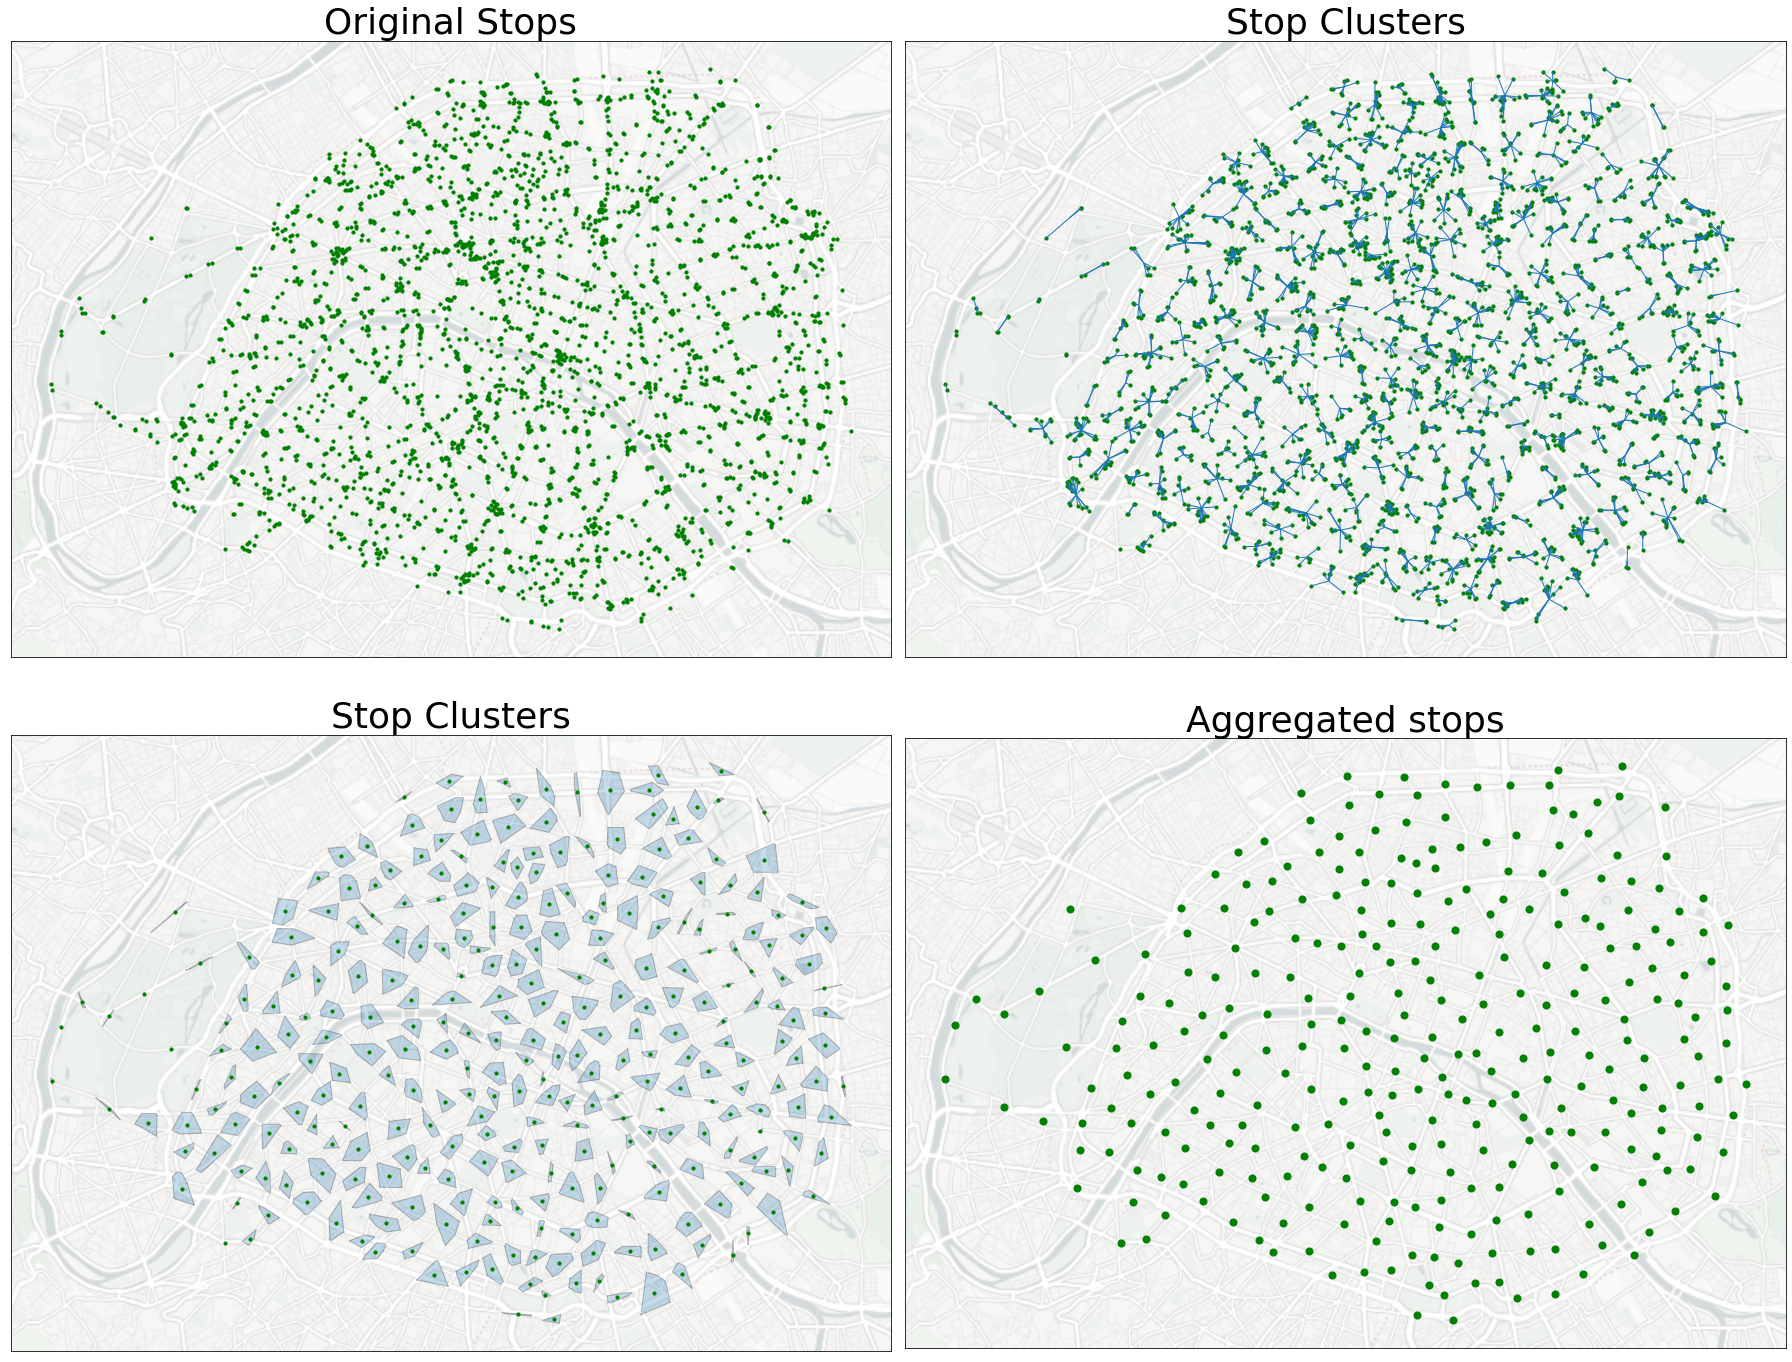

In [88]:
if manual:
    fig = plot_clustering(sm, url='http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png')

## walk model

In [89]:
def plot_walkmodel(self, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True)
    plot = sm.plot('centroids', color='red', markersize=100,
        ax=sm.plot('nodes', markersize=10, color='red',
            ax=sm.plot('zone_to_transit', linewidth=1,
                      ax=sm.plot('zones', linewidth=1, alpha=1, edgecolor='black', color='none', 
                                ax=sm.plot('footpaths', alpha=0, ax=ax_array[0][0])))
        ),
        basemap_url=url,
        title="Acces and Egress links (Zone to Transit)", fontsize=36
    )
    plot = sm.plot(
        'footpaths', color=None, linewidth=1,
        ax=sm.plot('nodes', markersize=100, ax=sm.plot('zones',alpha=0, ax=ax_array[0][1])),
        basemap_url=url, title="Stops & Footpaths", fontsize=36
    )

    plot = sm.plot(
        'footpaths', color=None, linewidth=1,
        ax=sm.plot('zone_to_transit', linewidth=1,  ax=sm.plot('zones',alpha=0, ax=ax_array[1][0]) ),
        basemap_url=url,
        title="Full Pedestrian Graph (as the Crow Flies)", fontsize=36
    )
    plot = sm.plot('road_links', color='green',linewidth=0.5, ax=sm.plot(
        'road_to_transit',  linewidth=1, color='green',
        ax=sm.plot('zone_to_road', linewidth=1, color='green', ax=sm.plot('zones',alpha=0, ax=ax_array[1][1]) )),
        basemap_url=url,
        title="Full Pedestrian Graph (Walk on Road)", fontsize=36
    )
    return fig

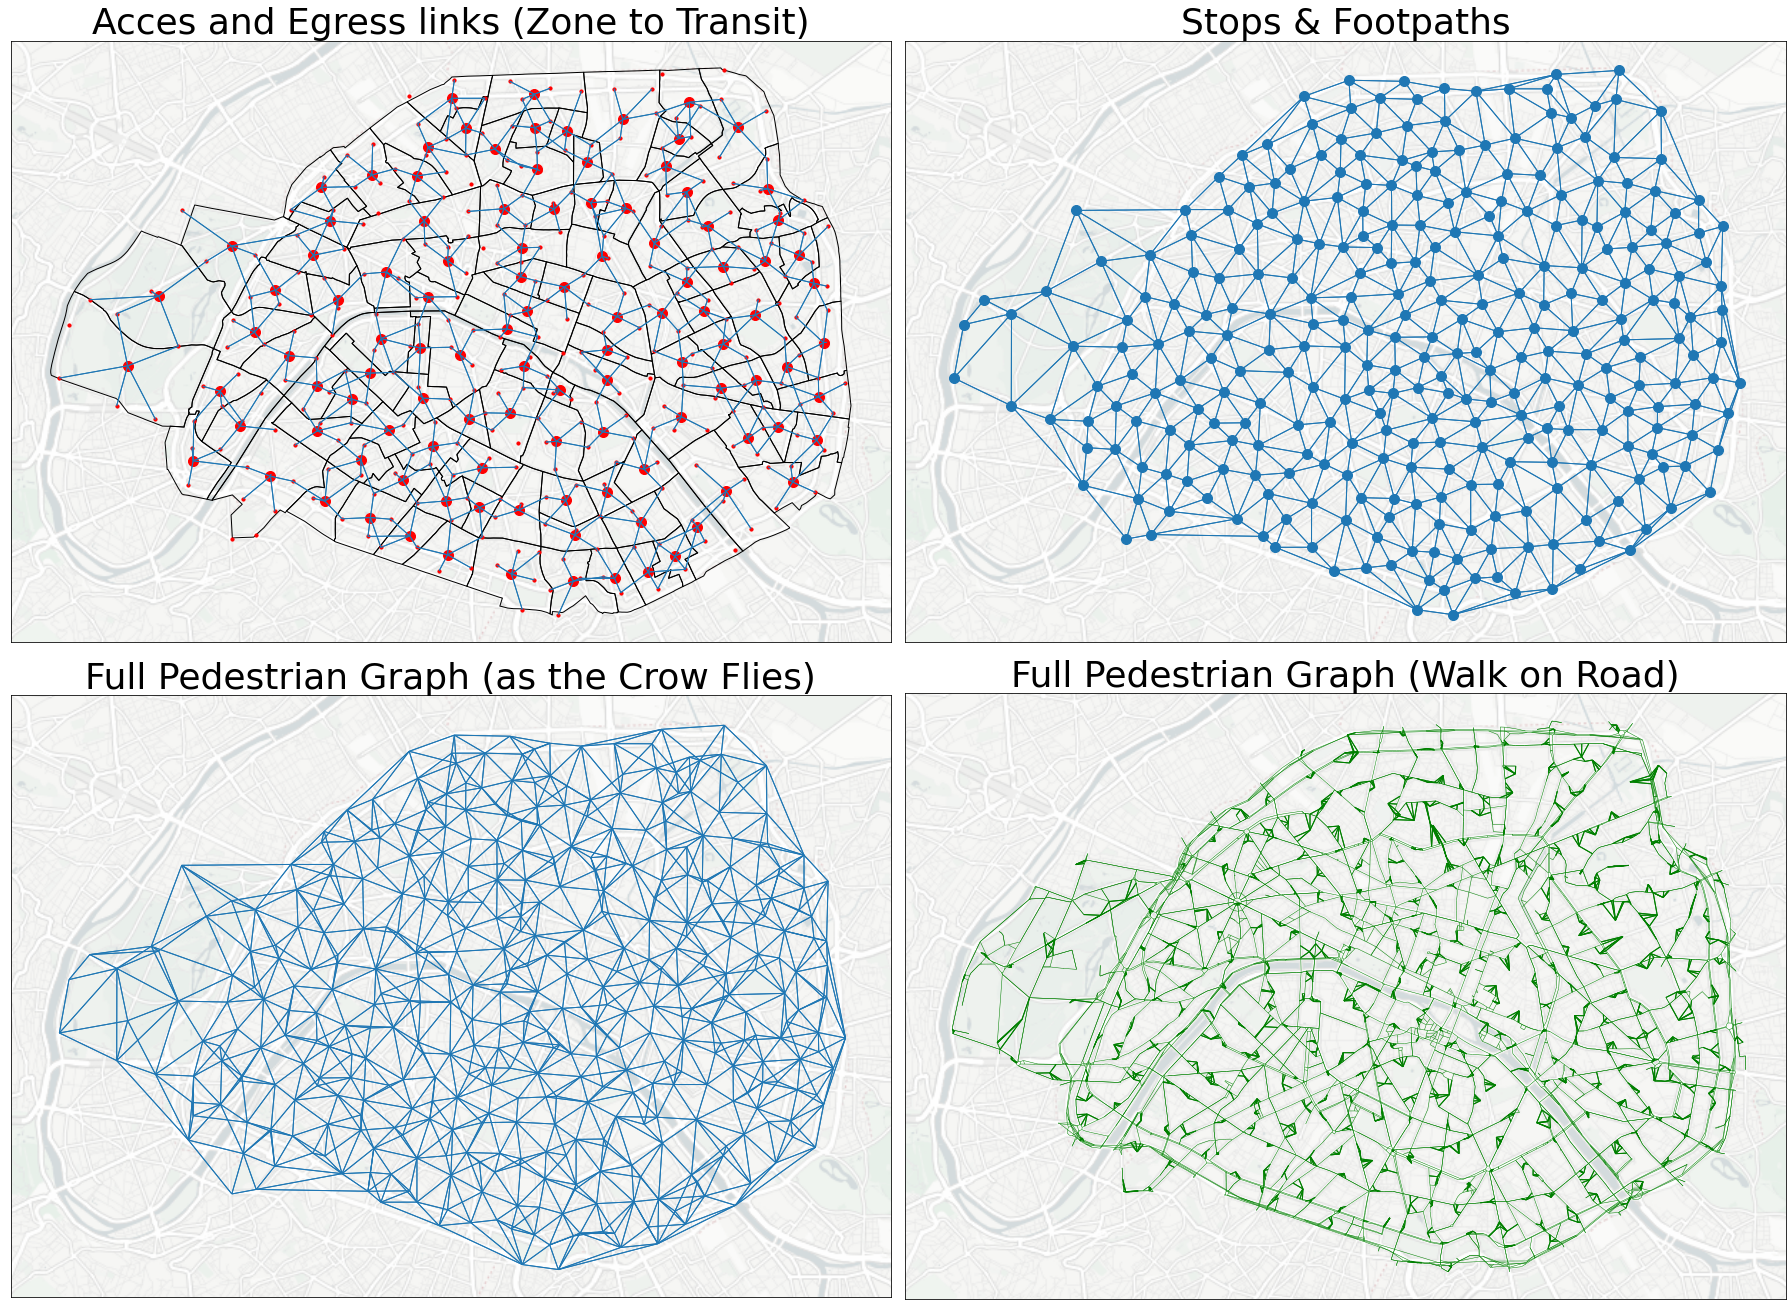

In [90]:
if manual:
    fig = plot_walkmodel(sm, url = 'http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png')

# zone_to_transit monitoring

In [91]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Access & egress links: speed VS distance')

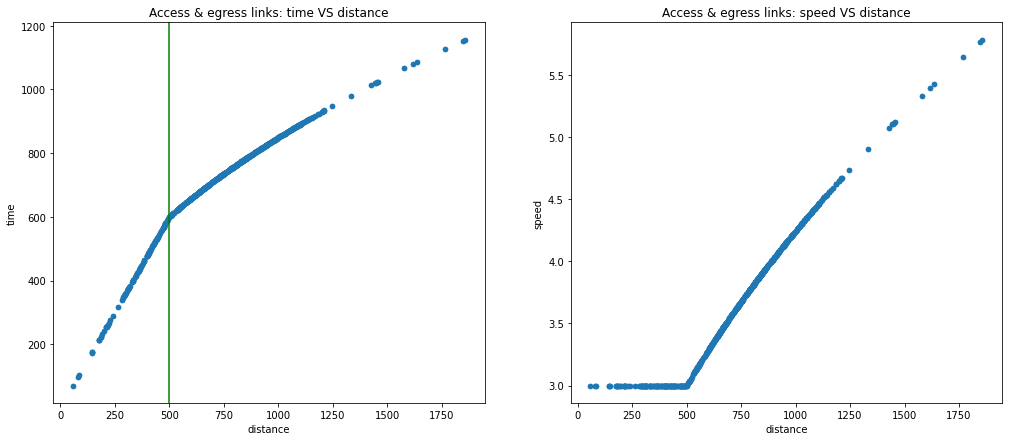

In [92]:
fig, axes = plt.subplots(1, 2, figsize=[17, 7])
ax = sm.zone_to_transit.plot(kind='scatter', x='distance', y='time', ax=axes[0])
ax.axvline(x=var["preparation_ntlegs"]["threshold"], color='green')
ax.set_title('Access & egress links: time VS distance')
ax = sm.zone_to_transit.plot(kind='scatter', x='distance', y='speed', ax=axes[1])
ax.set_title('Access & egress links: speed VS distance')